## Load the corpus

We use a labeled Movie Review Dataset to implement a simple supervised machine learning approach. The dataset contains 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews.
Our goal is to train a classifier that can predict whether a sentence is positive or negative.

This data was first used in Bo Pang and Lillian Lee, ``Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales.'', Proceedings of the ACL, 2005. Please find more information on the dataset here.
https://huggingface.co/datasets/rotten_tomatoes

Data labeling: "the movie-review “snippets” (a striking extract usually one sentence long) downloaded from www.rottentomatoes.com; each
snippet was labeled with its source review’s label
(positive or negative) as provided by Rotten Tomatoes." (Pang & Lee, 2005) p.119)

In [82]:
# !pip install scikit-learn nltk shap lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score, auc, average_precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from collections import defaultdict
import math

import shap, lime
from lime.lime_text import LimeTextExplainer



In [38]:
# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/petrotolochko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [39]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [40]:


# Load the dataset with specified encoding
reviews = pd.read_csv("reviews.csv", encoding='latin1')  # Use 'latin1' encoding for non-UTF-8 characters

# Inspect the data
print(reviews.head())  # Display the first few rows
print(reviews.info())  # General information about the dataset


                                               value  polarity
0  the rock is destined to be the 21st century's ...  positive
1  the gorgeously elaborate continuation of " the...  positive
2                     effective but too-tepid biopic  positive
3  if you sometimes like to go to the movies to h...  positive
4  emerges as something rare , an issue movie tha...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10662 entries, 0 to 10661
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   value     10662 non-null  object
 1   polarity  10662 non-null  object
dtypes: object(2)
memory usage: 166.7+ KB
None


# Inspecting the data

In [41]:
# View column names
print(reviews.columns)

# Rename the column 'value' to 'text'
reviews.rename(columns={'value': 'text'}, inplace=True)

# Check the class of the 'text' column
print(type(reviews['text']))

# Check the distribution of the outcome variable ('polarity')
print(reviews['polarity'].value_counts())

# Check the class of the 'polarity' column
print(type(reviews['polarity']))


Index(['value', 'polarity'], dtype='object')
<class 'pandas.core.series.Series'>
polarity
positive    5331
negative    5331
Name: count, dtype: int64
<class 'pandas.core.series.Series'>


In [42]:


# Create an ID column for each document
reviews['id_numeric'] = range(1, len(reviews) + 1)

# Split data into training and test sets (80% train, 20% test)
np.random.seed(657)  # Set random seed for reproducibility
id_train, id_test = train_test_split(reviews['id_numeric'], test_size=0.2, random_state=657)

# Tokenization, stopword removal, and stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Apply stemming
    return tokens


In [43]:

# Apply preprocessing to the 'text' column
reviews['processed_text'] = reviews['text'].apply(preprocess)


In [44]:
reviews

,text,polarity,id_numeric,processed_text
0,the rock is destined to be the 21st century's ...,positive,1,"[rock, destin, centuri, new, conan, go, make, ..."
1,"the gorgeously elaborate continuation of "" the...",positive,2,"[gorgeous, elabor, continu, lord, ring, trilog..."
2,effective but too-tepid biopic,positive,3,"[effect, biopic]"
3,if you sometimes like to go to the movies to h...,positive,4,"[sometim, like, go, movi, fun, wasabi, good, p..."
4,"emerges as something rare , an issue movie tha...",positive,5,"[emerg, someth, rare, issu, movi, honest, keen..."
...,...,...,...,...
10657,a terrible movie that some people will neverth...,negative,10658,"[terribl, movi, peopl, nevertheless, find, move]"
10658,there are many definitions of 'time waster' bu...,negative,10659,"[mani, definit, waster, movi, must, sure, one]"
10659,"as it stands , crocodile hunter has the hurrie...",negative,10660,"[stand, crocodil, hunter, hurri, badli, cobbl,..."
10660,the thing looks like a made-for-home-video qui...,negative,10661,"[thing, look, like, quicki]"


In [45]:

# Convert processed text into a document-term matrix (DFM)
vectorizer = CountVectorizer(analyzer=lambda x: x)  # Pass pre-tokenized text

dfm_reviews = vectorizer.fit_transform(reviews['processed_text'])

# Trim the DFM by minimum document frequency (min_docfreq=2)
min_docfreq = 2
dfm_trimmed = dfm_reviews[:, np.array((dfm_reviews > 0).sum(axis=0)).flatten() >= min_docfreq]

# Split the DFM into training and test sets
train_mask = reviews['id_numeric'].isin(id_train).to_numpy()
test_mask = reviews['id_numeric'].isin(id_test).to_numpy()

dfm_train = dfm_trimmed[train_mask, :]
dfm_test = dfm_trimmed[test_mask, :]

In [46]:
dfm_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 80562 stored elements and shape (8529, 7216)>

In [47]:
dfm_test

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20389 stored elements and shape (2133, 7216)>

In [48]:
# Summary of results
print("DFM Shape (Full):", dfm_reviews.shape)
print("DFM Shape (Trimmed):", dfm_trimmed.shape)
print("Training Set Shape:", dfm_train.shape)
print("Test Set Shape:", dfm_test.shape)


DFM Shape (Full): (10662, 11969)
DFM Shape (Trimmed): (10662, 7216)
Training Set Shape: (8529, 7216)
Test Set Shape: (2133, 7216)



# Training


In [49]:

# Encode the target variable (polarity) as numerical values
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(reviews.loc[train_mask, 'polarity'])
y_test = label_encoder.transform(reviews.loc[test_mask, 'polarity'])


In [50]:
y_test

array([1, 1, 1, ..., 0, 0, 0], shape=(2133,))

In [51]:

# Create a Multinomial Naive Bayes model
# Scikit-learn's MultinomialNB uses term frequencies directly
model_nb = MultinomialNB()

# model_nb = MultinomialNB(class_prior=[0.5, 0.5])  # Example: Equal priors


# Fit the model on the training data
model_nb.fit(dfm_train, y_train)

# Model summary
print("Classes:", label_encoder.classes_)
print("Class Log Prior (from docfreq):", model_nb.class_log_prior_)


Classes: ['negative' 'positive']
Class Log Prior (from docfreq): [-0.69209251 -0.69420296]


In [52]:
np.log(0.5)

np.float64(-0.6931471805599453)

In [53]:
# Encode the target variable (polarity) as numerical values
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(reviews.loc[train_mask, 'polarity'])
y_test = label_encoder.transform(reviews.loc[test_mask, 'polarity'])

# Create and train the SVM model
model_svm = LinearSVC()  # Linear kernel SVM suitable for high-dimensional sparse data
model_svm.fit(dfm_train, y_train)

# Model summary
print("Classes:", label_encoder.classes_)

Classes: ['negative' 'positive']


# Predict for the test set (NB)


In [55]:
# Predict for the test set using Naive Bayes
y_pred_nb = model_nb.predict(dfm_test)

# Decode predictions back to original labels
y_pred_nb_decoded = label_encoder.inverse_transform(y_pred_nb)

# Summary of predictions
print("Naive Bayes Predictions Summary:")
print(pd.Series(y_pred_nb_decoded).value_counts())


Naive Bayes Predictions Summary:
negative    1085
positive    1048
Name: count, dtype: int64


In [56]:
# Summary of the Naive Bayes model
print("Naive Bayes Model Class Log Priors:")
print(model_nb.class_log_prior_)

print("Naive Bayes Model Feature Log Probabilities:")
print(model_nb.feature_log_prob_)  # Log probabilities of features per class


Naive Bayes Model Class Log Priors:
[-0.69209251 -0.69420296]
Naive Bayes Model Feature Log Probabilities:
[[ -9.38128496  -8.82166917 -10.07443214 ...  -9.66896703  -9.1581414
  -10.07443214]
 [-10.79536263  -9.40906827 -10.10221545 ... -10.79536263  -8.71592109
  -10.10221545]]


# Predict for test set (SVM)

In [57]:
# Predict for the test set using SVM
y_pred_svm = model_svm.predict(dfm_test)

# Decode predictions back to original labels
y_pred_svm_decoded = label_encoder.inverse_transform(y_pred_svm)

# Summary of predictions
print("SVM Predictions Summary:")
print(pd.Series(y_pred_svm_decoded).value_counts())


SVM Predictions Summary:
negative    1099
positive    1034
Name: count, dtype: int64


# Precision / Recall / F1 Scores

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$


$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


$$
\text{Macro F1-Score} = \frac{1}{C} \sum_{i=1}^{C} F_1^i
$$



In [58]:
# Assume y_test is the ground truth and predictions are already made
# y_test: True labels for the test set
# y_pred_nb: Predictions from Naive Bayes
# y_pred_svm: Predictions from SVM

def calculate_metrics(y_true, y_pred):
    """
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    Returns:
        dict: Metrics for each class.
    """
    # Get unique classes
    classes = set(y_true)
    metrics = {}

    for cls in classes:
        # True Positives (TP)
        tp = sum((y_pred[i] == cls) and (y_true[i] == cls) for i in range(len(y_true)))
        # False Positives (FP)
        fp = sum((y_pred[i] == cls) and (y_true[i] != cls) for i in range(len(y_true)))
        # False Negatives (FN)
        fn = sum((y_pred[i] != cls) and (y_true[i] == cls) for i in range(len(y_true)))

        # Precision, Recall, F1-Score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Store metrics for the class
        metrics[cls] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        }

    return metrics


In [59]:

# Decode y_test to original labels (if necessary)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Decode predictions to original labels
y_pred_nb_decoded = label_encoder.inverse_transform(y_pred_nb)
y_pred_svm_decoded = label_encoder.inverse_transform(y_pred_svm)

# Calculate metrics for Naive Bayes
nb_metrics = calculate_metrics(y_test_decoded, y_pred_nb_decoded)

# Calculate metrics for SVM
svm_metrics = calculate_metrics(y_test_decoded, y_pred_svm_decoded)

# Display results
print("Metrics for Naive Bayes:")
for cls, scores in nb_metrics.items():
    print(f"Class: {cls}")
    print(f"  Precision: {scores['Precision']:.2f}")
    print(f"  Recall: {scores['Recall']:.2f}")
    print(f"  F1-Score: {scores['F1-Score']:.2f}")

print("\nMetrics for SVM:")
for cls, scores in svm_metrics.items():
    print(f"Class: {cls}")
    print(f"  Precision: {scores['Precision']:.2f}")
    print(f"  Recall: {scores['Recall']:.2f}")
    print(f"  F1-Score: {scores['F1-Score']:.2f}")

Metrics for Naive Bayes:
Class: positive
  Precision: 0.77
  Recall: 0.76
  F1-Score: 0.77
Class: negative
  Precision: 0.76
  Recall: 0.78
  F1-Score: 0.77

Metrics for SVM:
Class: positive
  Precision: 0.75
  Recall: 0.72
  F1-Score: 0.73
Class: negative
  Precision: 0.73
  Recall: 0.75
  F1-Score: 0.74


# Accuracy

In [61]:
def compute_accuracy(y_true, y_pred):
    """
    Compute accuracy as the ratio of correctly predicted instances to the total instances.
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
    Returns:
        float: Accuracy value.
    """
    # Create a confusion matrix
    conf_mat = pd.crosstab(pd.Series(y_true, name="Actual"), pd.Series(y_pred, name="Predicted"))
    
    # Extract diagonal (correctly predicted instances)
    correct_predictions = conf_mat.to_numpy().diagonal().sum()
    total_instances = conf_mat.to_numpy().sum()
    
    # Calculate accuracy
    accuracy = correct_predictions / total_instances
    return accuracy

# Example usage with Naive Bayes predictions
accuracy_nb = compute_accuracy(y_test_decoded, y_pred_nb_decoded)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")

# Example usage with SVM predictions
accuracy_svm = compute_accuracy(y_test_decoded, y_pred_svm_decoded)
print(f"SVM Accuracy: {accuracy_svm:.2f}")


Naive Bayes Accuracy: 0.77
SVM Accuracy: 0.74


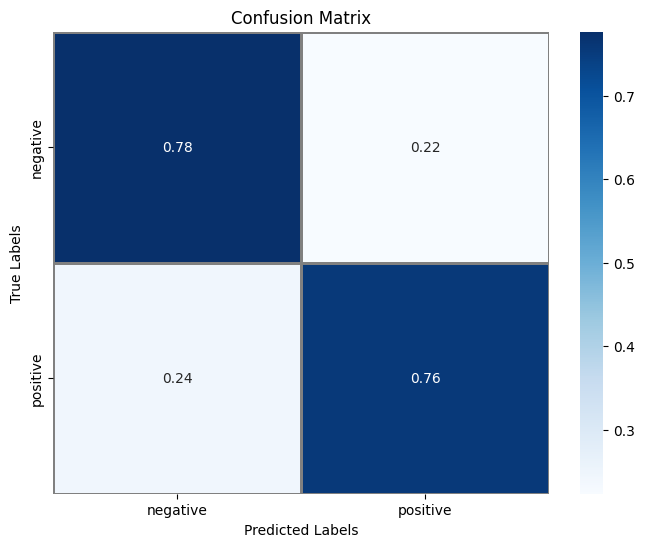

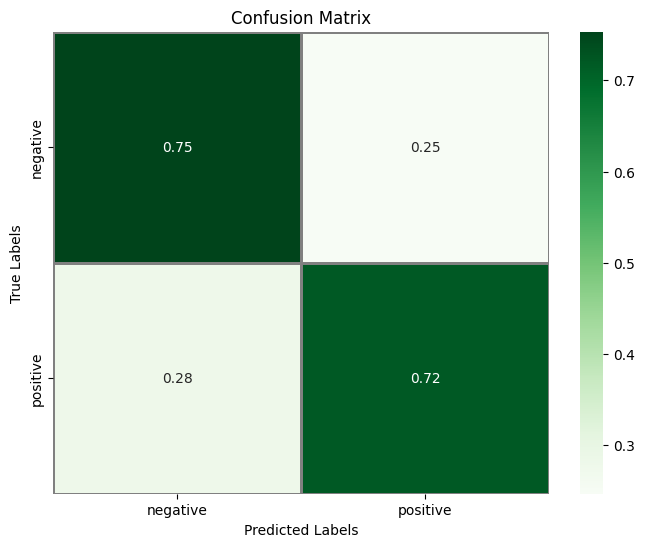

In [62]:


def plot_confusion_matrix(y_true, y_pred, color="Blues"):
    """
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        color (str): Color scheme for the heatmap.
    Returns:
        None
    """
    # Create a confusion matrix
    conf_mat = pd.crosstab(pd.Series(y_true, name="Actual"), pd.Series(y_pred, name="Predicted"))
    
    # Normalize rows to proportions
    conf_mat_normalized = conf_mat.div(conf_mat.sum(axis=1), axis=0)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_normalized, annot=True, fmt=".2f", cmap=color, cbar=True, linewidths=1, linecolor="gray")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Example usage with Naive Bayes predictions
plot_confusion_matrix(y_test_decoded, y_pred_nb_decoded, color="Blues")

# Example usage with SVM predictions
plot_confusion_matrix(y_test_decoded, y_pred_svm_decoded, color="Greens")


# K-Fold Cross-Validation

In [63]:

def k_fold_cross_validation(model, X, y, k=5):
    """
    Args:
        model: Machine learning model (e.g., Naive Bayes or SVM).
        X: Document-term matrix (features).
        y: Target labels.
        k: Number of folds for cross-validation.
    Returns:
        dict: Average precision, recall, F1-score, and accuracy across all folds.
    """
    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize metrics
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []
    
    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Compute metrics
        tp = sum((y_pred == y_test) & (y_test == 1))  # True positives
        fp = sum((y_pred == 1) & (y_test == 0))       # False positives
        fn = sum((y_pred == 0) & (y_test == 1))       # False negatives
        tn = sum((y_pred == y_test) & (y_test == 0))  # True negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        # Store metrics for this fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
    
    # Compute average metrics across all folds
    return {
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "Accuracy": np.mean(accuracy_scores)
    }

# Example Usage
# Encode labels (if not already numeric)
y_encoded = label_encoder.transform(reviews['polarity'])

# Naive Bayes
nb_model = MultinomialNB()
nb_metrics = k_fold_cross_validation(nb_model, dfm_reviews, y_encoded, k=20)
print("Naive Bayes Cross-Validation Metrics:", nb_metrics)

# SVM
svm_model = LinearSVC()
svm_metrics = k_fold_cross_validation(svm_model, dfm_reviews, y_encoded, k=20)
print("SVM Cross-Validation Metrics:", svm_metrics)


Naive Bayes Cross-Validation Metrics: {'Precision': np.float64(0.7701043559554597), 'Recall': np.float64(0.7709377143350786), 'F1-Score': np.float64(0.7703188911019657), 'Accuracy': np.float64(0.7704947263387931)}
SVM Cross-Validation Metrics: {'Precision': np.float64(0.7308349941940676), 'Recall': np.float64(0.7376857002304927), 'F1-Score': np.float64(0.733967888214391), 'Accuracy': np.float64(0.7335411528272586)}


In [64]:


def loo_cross_validation(model, X, y):
    loo = LeaveOneOut()
    y_true_all, y_pred_all = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # collect
        y_true_all.append(int(y_test[0]))
        y_pred_all.append(int(y_pred[0]))

    # compute metrics once, globally
    precision = precision_score(y_true_all, y_pred_all, zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, zero_division=0)
    accuracy = accuracy_score(y_true_all, y_pred_all)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy
    }

In [66]:
dfm_reviews

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 105704 stored elements and shape (10662, 11969)>

In [65]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(reviews["polarity"])

nb_model = MultinomialNB()
svm_model = LinearSVC()

nb_metrics = loo_cross_validation(nb_model, dfm_reviews, y_encoded)
print("Naive Bayes LOOCV:", nb_metrics)

# svm_metrics = loo_cross_validation(svm_model, dfm_reviews, y_encoded)
# print("SVM LOOCV:", svm_metrics)

Naive Bayes LOOCV: {'Precision': 0.7707472775065716, 'Recall': 0.7700243856687301, 'F1-Score': 0.7703856620061931, 'Accuracy': 0.770493340836616}


## Fast Leave-One-Out Approximation (Vectorized)
We use scikit-learn's `cross_val_predict` to emulate LOOCV efficiently.
It fits the model n_splits times and returns out-of-sample predictions for all observations.


In [68]:


nb_model = MultinomialNB()
svm_model = LinearSVC()

# Approximate LOOCV with 20-fold CV
y_pred_nb = cross_val_predict(nb_model, dfm_reviews, y_encoded, cv=100, n_jobs=-1)
y_pred_svm = cross_val_predict(svm_model, dfm_reviews, y_encoded, cv=100, n_jobs=-1)

def evaluate_model(y_true, y_pred, label):
    return {
        "Model": label,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, y_pred)
    }

results = pd.DataFrame([
    evaluate_model(y_encoded, y_pred_nb, "Naive Bayes"),
    evaluate_model(y_encoded, y_pred_svm, "SVM")
]).set_index("Model")

display(results.round(3))

,Precision,Recall,F1-Score,Accuracy
Model,,,,
Naive Bayes,0.770,0.768,0.769,0.769
SVM,0.732,0.741,0.736,0.735


# Area Under PR-Curve

In [69]:

def precision_recall_curve(y_true, y_scores):
    """
    Args:
        y_true (list or np.array): True binary labels (0 or 1).
        y_scores (list or np.array): Predicted scores or probabilities.
    Returns:
        tuple: Precision, recall, and thresholds.
    """
    # Sort by descending scores
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = np.array(y_true)[sorted_indices]
    y_scores_sorted = np.array(y_scores)[sorted_indices]
    
    # Initialize variables
    tp = 0
    fp = 0
    fn = sum(y_true)  # All positives initially not predicted
    precision = []
    recall = []
    thresholds = []

    # Iterate over sorted scores
    for i, score in enumerate(y_scores_sorted):
        if y_true_sorted[i] == 1:
            tp += 1  # True positive
            fn -= 1  # One less false negative
        else:
            fp += 1  # False positive
        
        # Compute precision and recall
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision.append(prec)
        recall.append(rec)
        thresholds.append(score)
    
    return np.array(precision), np.array(recall), np.array(thresholds)

def auc_pr(recall, precision):
    """
    Compute the area under the precision-recall curve.
    Args:
        recall (np.array): Recall values.
        precision (np.array): Precision values.
    Returns:
        float: Area under the curve.
    """
    return np.trapeze(precision, recall)  # Use the trapezoidal rule


Naive Bayes AUC-PR (integral): 0.832
Naive Bayes Average Precision: 0.833
SVM AUC-PR (integral): 0.783
SVM Average Precision: 0.785


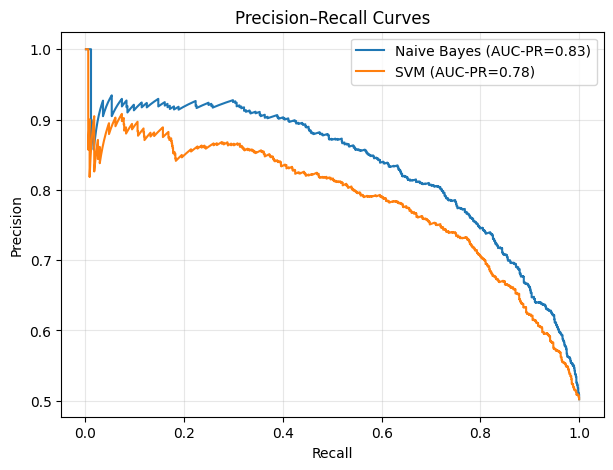

In [70]:

# Naive Bayes
y_scores_nb = model_nb.predict_proba(dfm_test)[:, 1]  # P(class=1)
y_true = y_test

precision_nb, recall_nb, _ = precision_recall_curve(y_true, y_scores_nb)
auc_pr_nb = auc(recall_nb, precision_nb)
avg_prec_nb = average_precision_score(y_true, y_scores_nb)

print(f"Naive Bayes AUC-PR (integral): {auc_pr_nb:.3f}")
print(f"Naive Bayes Average Precision: {avg_prec_nb:.3f}")

# SVM 
y_scores_svm = model_svm.decision_function(dfm_test)
precision_svm, recall_svm, _ = precision_recall_curve(y_true, y_scores_svm)
auc_pr_svm = auc(recall_svm, precision_svm)
avg_prec_svm = average_precision_score(y_true, y_scores_svm)

print(f"SVM AUC-PR (integral): {auc_pr_svm:.3f}")
print(f"SVM Average Precision: {avg_prec_svm:.3f}")


plt.figure(figsize=(7,5))
plt.plot(recall_nb, precision_nb, label=f"Naive Bayes (AUC-PR={auc_pr_nb:.2f})")
plt.plot(recall_svm, precision_svm, label=f"SVM (AUC-PR={auc_pr_svm:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Base Python NB Classifier

In [71]:

class NaiveBayesClassifier:
    def __init__(self):
        self.classes = set()  # Set of unique classes
        self.word_counts = defaultdict(lambda: defaultdict(int))  # Word frequency per class
        self.class_counts = defaultdict(int)  # Total word count per class
        self.total_docs = 0  # Total number of documents
        self.doc_counts = defaultdict(int)  # Document count per class
    
    def train(self, X, y):
        """
        Train the Naive Bayes classifier.
        
        Parameters:
            X (list of lists): List of documents, each represented as a list of words.
            y (list): Corresponding class labels for each document.
        """
        self.total_docs = len(y)
        self.classes = set(y)
        
        for text, label in zip(X, y):
            self.doc_counts[label] += 1
            for word in text:
                self.word_counts[label][word] += 1
                self.class_counts[label] += 1
    
    def predict(self, text):
        """
        Predict the class for a given text.
        
        Parameters:
            text (list): A document represented as a list of words.
        
        Returns:
            str: The predicted class label.
        """
        log_probs = {}
        total_words = sum(self.class_counts.values())
        
        for c in self.classes:
            # Log of the prior probability P(Class)
            log_prior = math.log(self.doc_counts[c] / self.total_docs)
            
            # Log of the likelihood P(Text|Class)
            log_likelihood = 0
            for word in text:
                word_count = self.word_counts[c][word] + 1  # Add-1 smoothing
                class_word_total = self.class_counts[c] + total_words  # Total words in class + smoothing
                log_likelihood += math.log(word_count / class_word_total)
            
            log_probs[c] = log_prior + log_likelihood
        
        # Return the class with the highest posterior probability
        return max(log_probs, key=log_probs.get)


In [72]:

# Step 1: Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenize, remove punctuation and stop words, and lowercase
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]  # Keep only alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply preprocessing
reviews['processed_text'] = reviews['text'].apply(preprocess)

# Step 2: Split the data into training and testing sets
X = reviews['processed_text'].tolist()  # List of tokenized documents
y = reviews['polarity'].tolist()        # List of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(X_train, y_train)

# Step 4: Make predictions
y_pred = [nb_classifier.predict(text) for text in X_test]

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7576183778715424
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.74      0.75      1071
    positive       0.75      0.77      0.76      1062

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133



## Model Complexity and Overfitting

We'll vary the model's regularization strength (`C`) in Logistic Regression.

Low C → strong regularization (simpler model, high bias)

High C → weak regularization (complex model, high variance)


/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/li

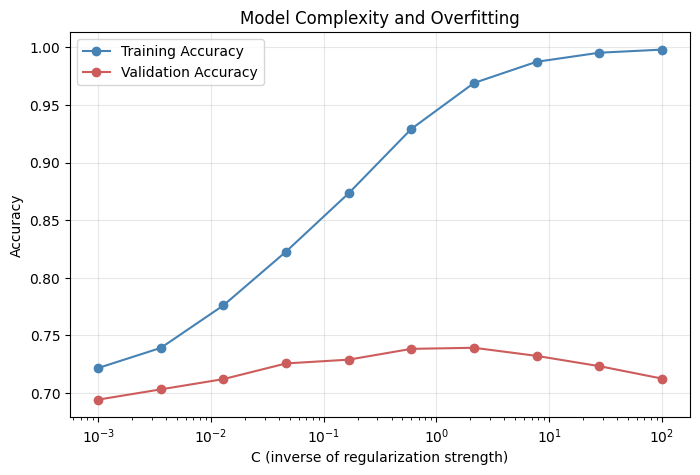

In [73]:


# Use the numeric feature matrix (sparse DTM or TF-IDF)
X = dfm_reviews  # or dfm_trimmed
y = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

C_values = np.logspace(-3, 2, 10)
train_scores = []
val_scores = []

for C in C_values:
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    val_acc = model.score(X_val, y_val)

    train_scores.append(train_acc)
    val_scores.append(val_acc)

plt.figure(figsize=(8, 5))
plt.plot(C_values, train_scores, marker='o', label='Training Accuracy', color='steelblue')
plt.plot(C_values, val_scores, marker='o', label='Validation Accuracy', color='indianred')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.title('Model Complexity and Overfitting')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

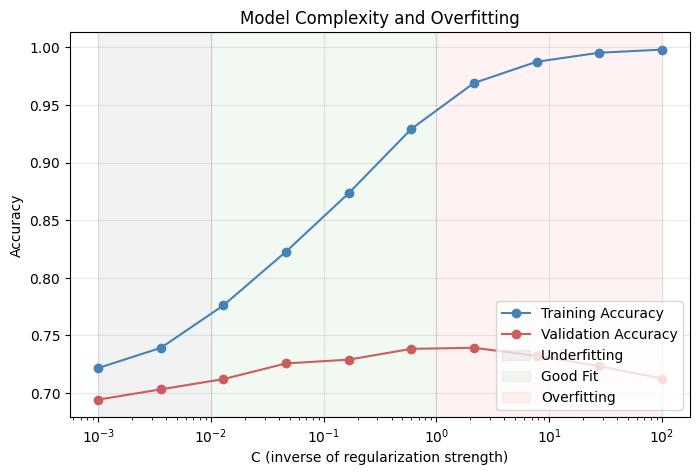

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(C_values, train_scores, marker='o', label='Training Accuracy', color='steelblue')
plt.plot(C_values, val_scores, marker='o', label='Validation Accuracy', color='indianred')
plt.xscale('log')

# Shaded regions
plt.axvspan(1e-3, 1e-2, color='gray', alpha=0.1, label='Underfitting')
plt.axvspan(1e-2, 1, color='green', alpha=0.05, label='Good Fit')
plt.axvspan(1, 1e2, color='red', alpha=0.05, label='Overfitting')

plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.title('Model Complexity and Overfitting')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Regularization: L1 vs L2 (Sparse vs Smooth Models)

L1 regularization (Lasso) → pushes many coefficients to exactly zero → *sparse* model.
L2 regularization (Ridge) → shrinks coefficients smoothly → *dense* model.

Both control overfitting, but they affect interpretability differently.


In [75]:

# Split data
X_train, X_val, y_train, y_val = train_test_split(dfm_reviews, y_encoded, test_size=0.2, random_state=42)

# Two models: L1 (lasso) and L2 (ridge)
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=1.0)
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, C=1.0)

model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)

# Evaluate
acc_l1 = model_l1.score(X_val, y_val)
acc_l2 = model_l2.score(X_val, y_val)

print(f"L1 Accuracy: {acc_l1:.3f}")
print(f"L2 Accuracy: {acc_l2:.3f}")

L1 Accuracy: 0.731
L2 Accuracy: 0.738


In [76]:
coef_l1 = model_l1.coef_.flatten()
coef_l2 = model_l2.coef_.flatten()

n_nonzero_l1 = np.sum(coef_l1 != 0)
n_nonzero_l2 = np.sum(coef_l2 != 0)

print(f"L1 Non-zero Coefficients: {n_nonzero_l1} / {len(coef_l1)}")
print(f"L2 Non-zero Coefficients: {n_nonzero_l2} / {len(coef_l2)}")

L1 Non-zero Coefficients: 1781 / 11969
L2 Non-zero Coefficients: 10984 / 11969


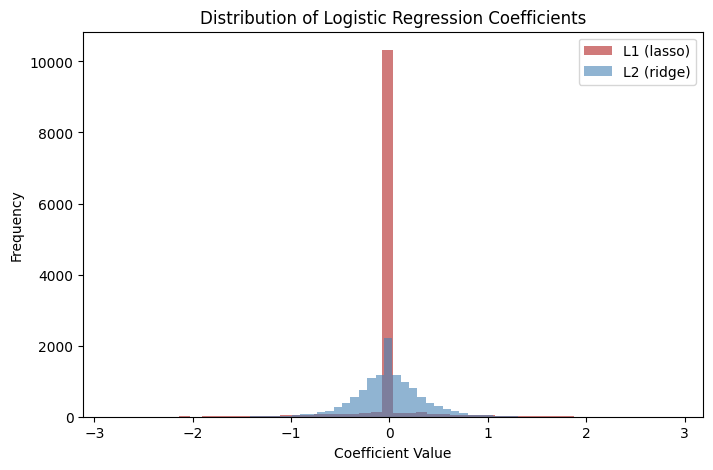

In [77]:
# %%
plt.figure(figsize=(8,5))
plt.hist(coef_l1, bins=50, alpha=0.6, label='L1 (lasso)', color='firebrick')
plt.hist(coef_l2, bins=50, alpha=0.6, label='L2 (ridge)', color='steelblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.title('Distribution of Logistic Regression Coefficients')
plt.legend()
plt.show()

In [78]:
feature_names = np.array(vectorizer.get_feature_names_out())

top_pos_l1 = feature_names[np.argsort(coef_l1)[-10:]]
top_neg_l1 = feature_names[np.argsort(coef_l1)[:10]]

top_pos_l2 = feature_names[np.argsort(coef_l2)[-10:]]
top_neg_l2 = feature_names[np.argsort(coef_l2)[:10]]

print("Top positive words (L1):", ", ".join(top_pos_l1))
print("Top negative words (L1):", ", ".join(top_neg_l1))
print("Top positive words (L2):", ", ".join(top_pos_l2))
print("Top negative words (L2):", ", ".join(top_neg_l2))

Top positive words (L1): delight, fulfil, unflinch, sli, happi, gloriou, unexpect, refresh, resist, engross
Top negative words (L1): routin, flat, whini, bore, badli, wast, sabotag, lush, unfunni, unpleas
Top positive words (L2): consider, solid, soul, resist, refresh, remark, unexpect, delight, happi, engross
Top negative words (L2): bore, neither, worst, dull, wast, fail, flat, routin, mildli, mediocr


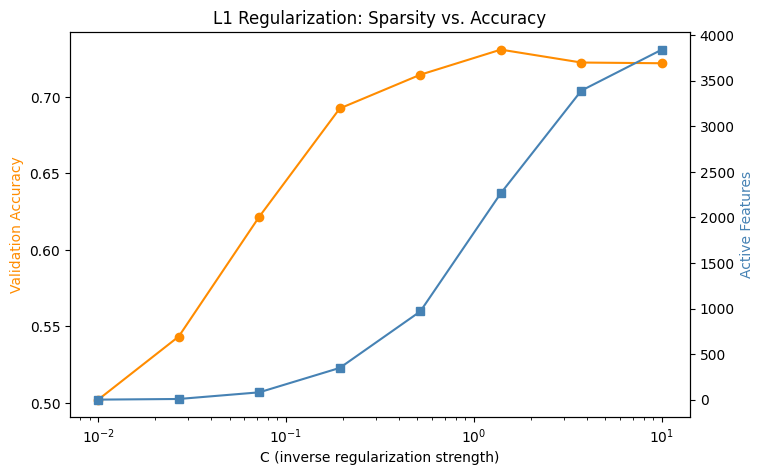

In [79]:
C_values = np.logspace(-2, 1, 8)
nonzero_counts = []
accuracies = []

for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train, y_train)
    nonzero_counts.append(np.sum(model.coef_.flatten() != 0))
    accuracies.append(model.score(X_val, y_val))

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(C_values, accuracies, marker='o', color='darkorange', label='Accuracy')
ax1.set_xscale('log')
ax1.set_xlabel('C (inverse regularization strength)')
ax1.set_ylabel('Validation Accuracy', color='darkorange')
ax2 = ax1.twinx()
ax2.plot(C_values, nonzero_counts, marker='s', color='steelblue', label='Non-zero Coefficients')
ax2.set_ylabel('Active Features', color='steelblue')
plt.title('L1 Regularization: Sparsity vs. Accuracy')
plt.show()

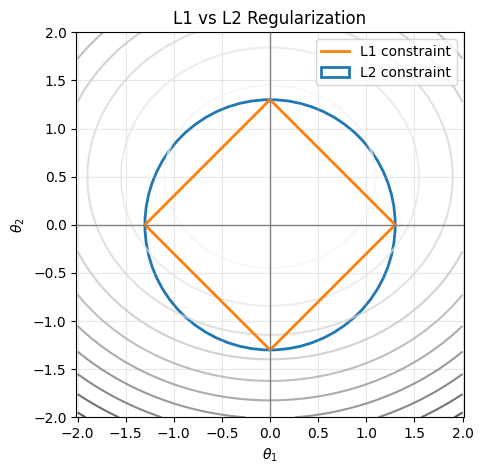

In [80]:
theta1, theta2 = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
loss = theta1**2 / 2 + 2*(theta2 - 0.5)**2 / 3  # elliptical contour

plt.figure(figsize=(5,5))
# Contours of loss
plt.contour(theta1, theta2, loss, levels=10, cmap='Greys', alpha=0.7)

# L2 constraint (circle)
circle = plt.Circle((0,0), 1.3, color='C0', fill=False, lw=2, label='L2 constraint')

# L1 constraint (diamond)
diamond = np.array([[0,1.3],[1.3,0],[0,-1.3],[-1.3,0],[0,1.3]])
plt.plot(diamond[:,0], diamond[:,1], color='C1', lw=2, label='L1 constraint')

plt.gca().add_patch(circle)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.legend()
plt.title("L1 vs L2 Regularization")
plt.grid(alpha=0.3)
plt.axis('equal')
plt.show()

# SHAP / LIME

Shapley values (from game theory) / Local Interpretable Model-agnostic Explanations

In [83]:

# Prepare raw text and labels
texts = reviews["text"]
labels = reviews["polarity"]

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
y = label_enc.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=1000, C=1.0)
clf.fit(X_train_tfidf, y_train)

print("Test accuracy:", clf.score(X_test_tfidf, y_test))

Test accuracy: 0.743553680262541


/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


In [86]:
# LIME: Local word-level explanation (fixed version)

explainer = LimeTextExplainer(class_names=label_enc.classes_)

# Pick an example review
i = 666
text_instance = X_test.iloc[i]
print("Text:", text_instance)
print("True label:", label_enc.classes_[y_test[i]])

# Wrapper for vectorizer + model
def predict_proba_wrapper(texts):
    return clf.predict_proba(tfidf.transform(texts))

exp = explainer.explain_instance(
    text_instance,
    predict_proba_wrapper,
    num_features=10,
    labels=[0, 1]
)

from IPython.display import HTML, display
display(HTML(exp.as_html()))

Text: it may not be particularly innovative , but the film's crisp , unaffected style and air of gentle longing make it unexpectedly rewarding . 
True label: positive


/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/sklea

In [87]:
# Shap

feature_names = tfidf.get_feature_names_out()

explainer = shap.LinearExplainer(
    clf,
    X_train_tfidf,
    feature_perturbation="interventional",
    feature_names=feature_names
)

shap_values = explainer(X_test_tfidf)

/Users/petrotolochko/miniconda3/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


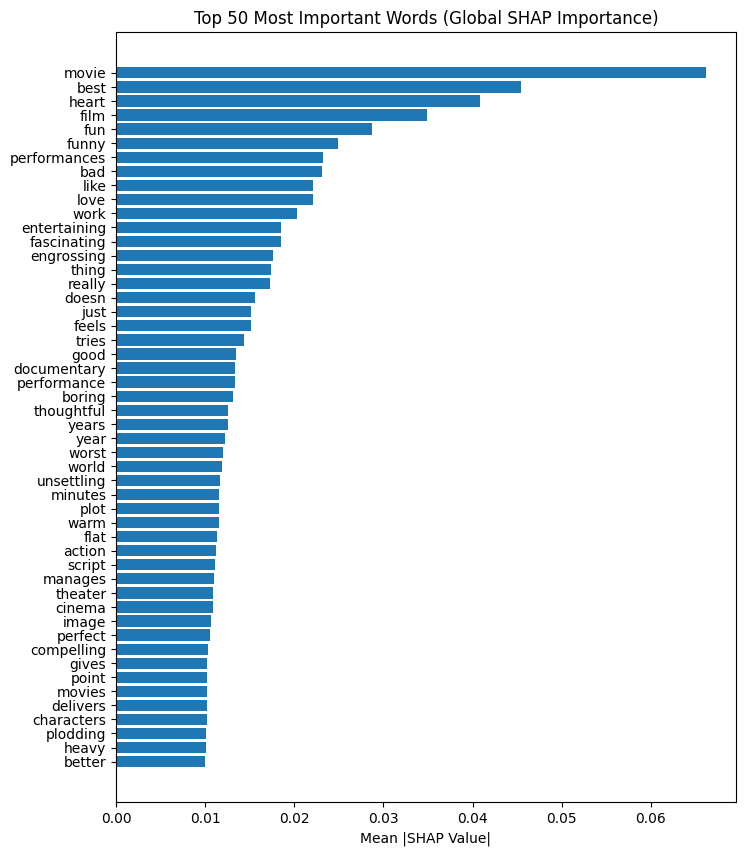

In [88]:
feature_names = tfidf.get_feature_names_out()
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

importance_df = (
    pd.DataFrame({"word": feature_names, "mean_abs_shap": mean_abs_shap})
    .sort_values("mean_abs_shap", ascending=False)
    .head(50)  # show top 50 words
)

plt.figure(figsize=(8, 10))
plt.barh(importance_df["word"], importance_df["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 50 Most Important Words (Global SHAP Importance)")
plt.show()

In [89]:
feature_names = tfidf.get_feature_names_out()
shap_matrix = shap_values.values  # shape: (n_samples, n_features)

# Mean SHAP value across all samples (signed)
mean_shap = shap_matrix.mean(axis=0)

# Separate top positive and top negative words
top_pos = (
    pd.DataFrame({"word": feature_names, "mean_shap": mean_shap})
    .sort_values("mean_shap", ascending=False)
    .head(10)
)

top_neg = (
    pd.DataFrame({"word": feature_names, "mean_shap": mean_shap})
    .sort_values("mean_shap", ascending=True)
    .head(10)
)

print("Top positive words:\n", top_pos)
print("\nTop negative words:\n", top_neg)

Top positive words:
           word  mean_shap
1672      film   0.010212
2905     movie   0.008961
1635  feathers   0.008889
4591     tries   0.008763
3449   purpose   0.007916
3262  plodding   0.007559
2916   mugging   0.006830
4465     thing   0.006464
4948     worse   0.006324
2835    mildly   0.005864

Top negative words:
              word  mean_shap
2054        heart  -0.029147
1415   engrossing  -0.014446
329           bad  -0.012894
4941         work  -0.011664
2412         just  -0.011090
4699   unsettling  -0.010237
391          best  -0.009737
2180        image  -0.009405
4823         warm  -0.009270
1613  fascinating  -0.009189


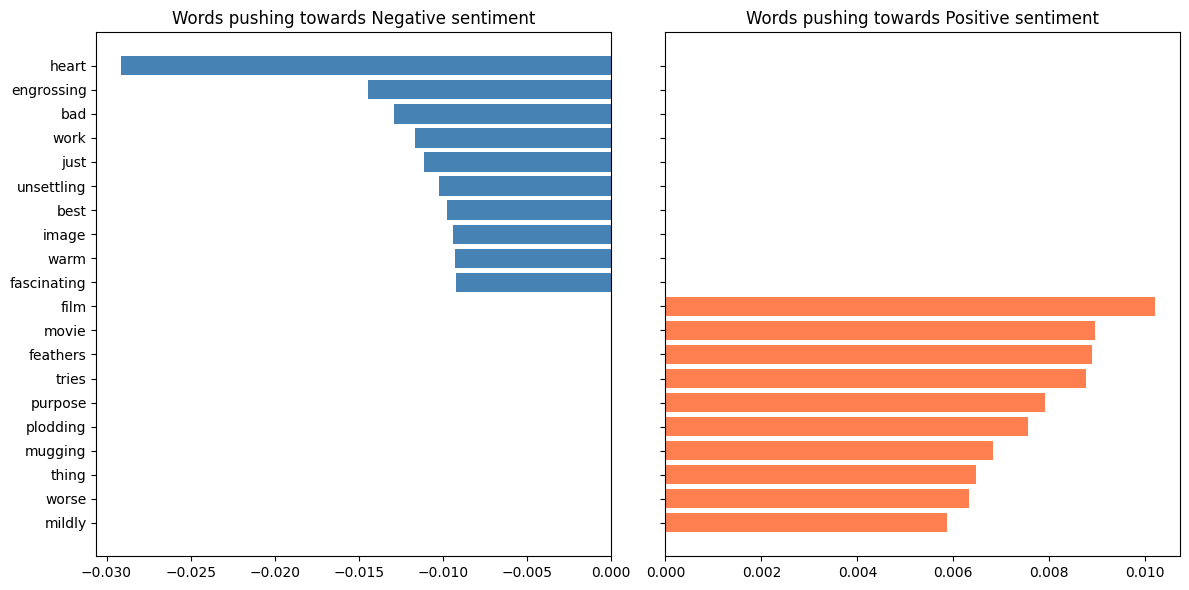

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax[0].barh(top_neg["word"], top_neg["mean_shap"], color="steelblue")
ax[0].set_title("Words pushing towards Negative sentiment")
ax[0].invert_yaxis()

ax[1].barh(top_pos["word"], top_pos["mean_shap"], color="coral")
ax[1].set_title("Words pushing towards Positive sentiment")

plt.tight_layout()
plt.show()

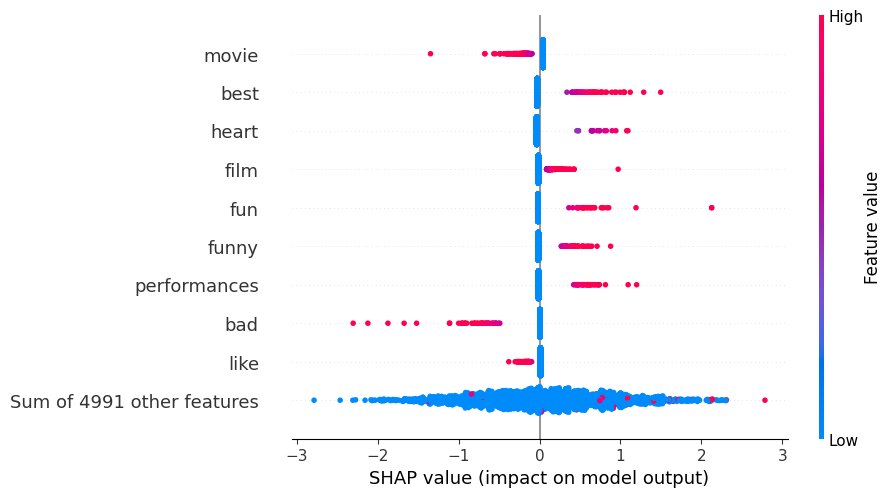

In [91]:
shap.plots.beeswarm(shap_values)